In [5]:
#import user modules
import utils.helper_functions as hfun
import config as cf
import modules.thouless_times as thouless
import modules.spectral_functions as spec_fun
import modules.sff as sff_module
import modules.adiabatics as agp
import modules.anderson as anderson
import costfun.costfun as cost
import importlib
from utils.fit_functions import *
def reload_modules():
    importlib.reload(anderson)
    importlib.reload(hfun)
    importlib.reload(cf)
    importlib.reload(thouless)
    importlib.reload(spec_fun)
    importlib.reload(agp)
    importlib.reload(sff_module)
    importlib.reload(cost)

reload_modules()

from utils.fit_functions import *
#--- importet in user module
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
import os
from utils import exit
from os import sep as kPSep
from os.path import exists

#--- other modules
import numpy as np
import itertools
import seaborn as sns
import pandas as pd
import math
import random
import imageio
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from joblib import Parallel, delayed
import copy
#plt.style.use(['science','ieee','no-latex'])

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
latex_engine = 'xelatex'
latex_elements = {'preamble':r'\usepackage{physics}'}
# get all the colors
import matplotlib.colors as mcolors
from scipy.special import binom
import sympy as sym
from scipy.optimize import curve_fit as fit
from scipy.signal import savgol_filter

print(cf.base_directory)
from cmath import nan
import h5py    


user_settings = getattr(cf.plot_settings, 'settings')


../results/HEISENBERG/local_pert/OBC/


# BARTEK TESTS

[Errno 17] File exists: 'CriticalParameters_Bartek'


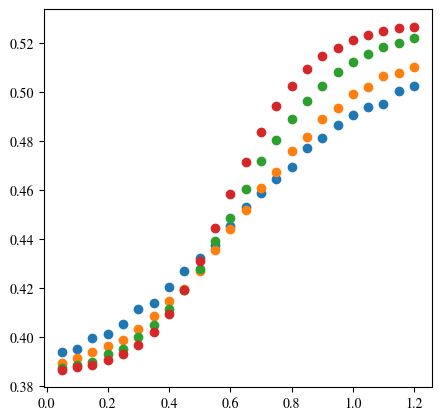

In [6]:
fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 100)

W=10.0
sizes = np.arange(10, 17, 2)
gvals = []
gap_ratio = []
for L in sizes:
    name = f'BARTEK_DATA/L{L}_W{W}_sqrt.dat'
    if os.path.exists(name):
        data = pd.read_table(name, sep=" ", header=None)
        gvals.append(data[0][1:])
        gap_ratio.append(data[1][1:])
        axis.scatter(data[0][1:], data[1][1:], label=r"$L=%d$"%L)


dir = "CriticalParameters_Bartek"
try:
    os.mkdir(dir)
except OSError as error:
    print(error)   


In [ ]:
reload_modules()

def collapse_data_eh(scaling_ansatz, crit_fun = 'free', W=10.0, seed=634634634):
    suffix = "_W=%.1f_critfun=%s_ansatz=%s_seed=%d"%(W, crit_fun, scaling_ansatz, seed)
    sizes = np.arange(10, 17, 2)
    gvals = []
    gap_ratio = []
    for L in sizes:
        name = f'BARTEK_DATA/L{L}_W{W}_sqrt.dat'
        if os.path.exists(name):
            data = pd.read_table(name, sep=" ", header=None)
            xval = data[0][1:]
            r = data[1][1:]
            xval.reset_index(drop=True, inplace=True)
            r.reset_index(drop=True, inplace=True)
            gvals.append(xval)
            gap_ratio.append(r)

    #-- calculate gap ratio collapse
    par, crit_pars, costfun, status = cost.get_crit_points(x=gvals, y=gap_ratio, vals=sizes, crit_fun=crit_fun, scaling_ansatz=scaling_ansatz, seed=seed)
    print("Gap Ratio:\t", par, crit_pars, costfun, status)
    if costfun > 3: 
        status = Failed
        assert False, "Cost function too high: CF = %d"%costfun
    if status:
        filename = dir + os.sep + "GapRatio" + suffix
        data = {
            "costfun": costfun,
            "crit exp'": par
        }
        for i in range(len(crit_pars)):
            data["x_%d"%i] = crit_pars[i]
        np.savez(filename, **data)


collapse_data_eh(scaling_ansatz='classic', crit_fun='free')
collapse_data_eh(scaling_ansatz='FGR', crit_fun='free')
collapse_data_eh(scaling_ansatz='KT', crit_fun='free')
collapse_data_eh(scaling_ansatz='RG', crit_fun='free')
random.seed(1e6)

In [7]:
import costfun.costfun as cost
def typical(data):
    return np.exp(np.sum(np.log(data) / len(data)))

W = 3.0
basedir = "./CriticalParameters_Bartek/"
def load_critical_bartek(crit_fun = 'free', scaling_ansatz = 'FGR', W=3.0):

    cost_fun = []
    crit_exp = []
    crit_exp2 = []
    crit_pars = []
    critical_fun = cost.crit_functions_dict[crit_fun]
    print(W)
    for file in os.listdir(basedir):
        prefix = "GapRatio" + "_W=%.1f_critfun=%s_ansatz=%s_seed="%(W, crit_fun, scaling_ansatz)
        if file.startswith(prefix):
            file = basedir + file
            if os.path.exists(file):
                data = np.load(file)
                cost_fun.append(data['costfun'])
                crit_exponents = data["crit exp'"]
                crit_exp.append(crit_exponents)
                critics = []
                for i in range(len(data) - 2):
                    critics.append(data["x_%d"%i])
                crit_pars.append(np.array(critics))
    num_of_sizes = len(crit_pars[0])
    crit_pars = np.transpose(crit_pars)
    return np.array(cost_fun), np.array(crit_exp), np.array(crit_pars), num_of_sizes

cost_fun, crit_exp, crit_pars, num_of_crit = load_critical_bartek(W=W)


print(np.median(crit_exp))
print([typical(crit_pars[i]) for i in range(num_of_crit)])

def plot_collapsed_data(axis, vs = 'g', crit_fun = 'free', scaling_ansatz = 'FGR', W = 10.0):
    name = "GapRatio"
    
    x = []
    y = []
    sizes = np.array(range(10,17,2))
    for L in sizes:
        name = f'BARTEK_DATA/L{L}_W{W}_sqrt.dat'
        if os.path.exists(name):
            data = pd.read_table(name, sep=" ", header=None)
            x.append(data[0])
            y.append(data[1])
    x = np.array(x)
    y = np.array(y)
    
    cost_fun, crit_exp, crit_pars, num_of_sizes = load_critical_bartek(crit_fun=crit_fun, scaling_ansatz=scaling_ansatz, W=W)
    num_of_sizes = min(num_of_sizes, len(sizes))
    print(num_of_sizes)
    lab = 'g'
    cost_fun = np.mean(cost_fun)
    crit_exp = np.median(crit_exp)
    crit_pars = np.array([np.median(crit_pars[i]) for i in range(num_of_sizes)])
    
    rescale_fun = cost.resc_functions_dict[scaling_ansatz]
    critical_fun = cost.crit_functions_dict[crit_fun]
    
    
    g_c_dev_GOE = []
    for i in range(num_of_sizes):
        xpoints = []
        xpoints = rescale_fun(x[i], sizes[i], critical_fun, crit_exp, *crit_pars)
        
        idx = 0
        var = 0
        while var < 0.525 and idx < xpoints.size - 1: 
            var = y[i][idx];  idx += 1;
        g_c_dev_GOE.append(x[i][idx])

        axis.scatter(xpoints, y[i],s=8, label=r"$L=%d$"%sizes[i])
    
    xlab = cost.scale_ansatz_label[scaling_ansatz](lab)
    #if scaling_ansatz == 'classic': xlab = "L / \\xi_0"
    ylalab = "r"
    hfun.set_plot_elements(axis = axis, ylabel = ylalab, xlabel = xlab, settings=user_settings, 
                            font_size=17, set_legend=True, xlim=(None, None), ylim=(None, None))
    axis.legend(loc='upper left', frameon=False, fontsize=16, handletextpad=0.001, bbox_to_anchor=(-0.1,1.02))
    
    axis.set_xscale('linear')
    axis.set_yscale('linear')
    axis.axhline(y=0.5307, xmin=0.35, xmax = 1, ls='--', color='black')
    axis.axhline(y=0.3867, xmin = 0, xmax=0.35, ls='--', color='black')
    axis.set_ylim(0.375, 0.54)
    width = 0.37
    height = 0.37
    left, bottom, width, height = [1 - width, 0.12, width, height / 0.8]
    ax = hfun.add_subplot_axes(axis, [left, bottom, width, height])

    def plot_fit(crit, label = r"$%s^*$"%lab, plot_line = True, color = 'black'):
        p = ax.plot(sizes, crit, color=color, label=label, linewidth=0, marker = 'o')
        
    
    plot_fit(crit = crit_pars, label = r"$%s^*\sim$"%lab, color = 'black')

    #plot_fit(crit = g_c_dev_GOE, label = r"$\tilde{%s}\sim$"%lab, plot_line = False, color = 'red')
    if False and vs == 'g':
        g_c_crossing = [np.nan, 0.028, 0.022, 0.014]
        plot_fit(crit = g_c_crossing, label = r"$%s_c\sim$"%lab, plot_line = False, color = 'green')
    
    hfun.set_plot_elements(axis = ax, ylabel = lab + "_{cr}", xlabel = "L", settings=user_settings, 
                            font_size=10, set_legend=False, xlim=(None, None), ylim=(None, None))
    ax.set_xlim(9, 17)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width, box.height * 0.8])
    ax.set_xscale('linear')
    ax.set_yscale('linear')
    #ax.legend(loc = 'lower center', bbox_to_anchor=(0.65, 0.95), frameon = True, fontsize = 10, ncol=1)
    
    titlee = r"$CF=%.4f\qquad\nu=%.4f$"%(cost_fun, 1./crit_exp if scaling_ansatz == 'classic' else crit_exp )
    
    axis.set_title(titlee)
    axis.tick_params(axis="both",which='major',direction="in",length=4)
    axis.tick_params(axis="both",which='minor',direction="in",length=2)
    ax.tick_params(axis="both",which='major',direction="in",length=4)
    ax.tick_params(axis="both",which='minor',direction="in",length=2)
    #ax.set_xlim(0., 1/9)
    #ax.set_ylim(0., None)


3.0
4.12383250032234
[0.4378276146849205, 0.3668950015484029, 0.313207634779147, 0.4776797531406201]


In [8]:

def plot_dist(crit_fun = 'free', scaling_ansatz = 'FGR', W = 5.0):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots( nrows=1, ncols=4, figsize=(14,4), dpi = 100, constrained_layout=True, sharey=False)    

    cost_fun, crit_exp, crit_pars, num_of_crit = load_critical_bartek(crit_fun=crit_fun, scaling_ansatz=scaling_ansatz, W=W)

    ylab = 'g'
    ax1.hist(crit_exp, bins = 40)
    ax1.set_title("critical exponent- " + r"$\nu$" + "\n -distribution")
    sizes = np.array(range(10, 17, 2))

    ax2.hist(cost_fun, bins = 40)
    ax2.set_title("cost func- " + r"$\mu$" + "\n -distribution")
    
    for i in range(num_of_crit):
        ax3.hist(crit_pars[i], bins = 30, label=r"$L=%d$"%(sizes[i]), histtype='bar', linewidth=3, stacked=True)

    hist, edge = np.histogram((crit_pars[-1]), bins = 30)
    ax3.set_ylim( None, 1.5*max( hist ) )
    ax3.set_title(r"$%s_c$"%ylab + " distribution\n for each system size")


    for i in range(num_of_crit):
        ax4.hist(np.log10(crit_pars[i]), bins = 30, label=r"$L=%d$"%(sizes[i]), histtype='step', linewidth=3)
    
    ax4.set_title(r"$log_{10}%s_c$"%ylab + " distribution\n for each system size")
    hist, edge = np.histogram(np.log10(crit_pars[-1]), bins = 20)
    ax4.set_ylim( None, 1.5*max( hist ) )
    
    ax3.legend(fontsize=8)
    ax4.legend(fontsize=8, loc='upper left')
    print(np.median(crit_exp))
    print([np.median(crit_pars[i]) for i in range(num_of_crit)])
    lab = ylab
    fig.suptitle("Scaling ansatz:\t" + r"$%s$"%cost.scale_ansatz_label[scaling_ansatz](lab), fontsize=16)


10.0
1.6787398395328756
[0.6285680422959603, 0.5858969188206926, 0.559176580955197, 0.62022303688385]
10.0
4.9680792239077665
[0.6656483084265379, 0.6160340088249252, 0.5798481012883339, 0.6706232085074365]
10.0
1.145398636737462
[0.19319671196731938, 0.21796236443155553, 0.24493584721913803, 0.07276220189255472]
10.0
0.5956821233672578
[0.6410469004690972, 0.5970932519704267, 0.5664618427213418, 0.6371814478846639]


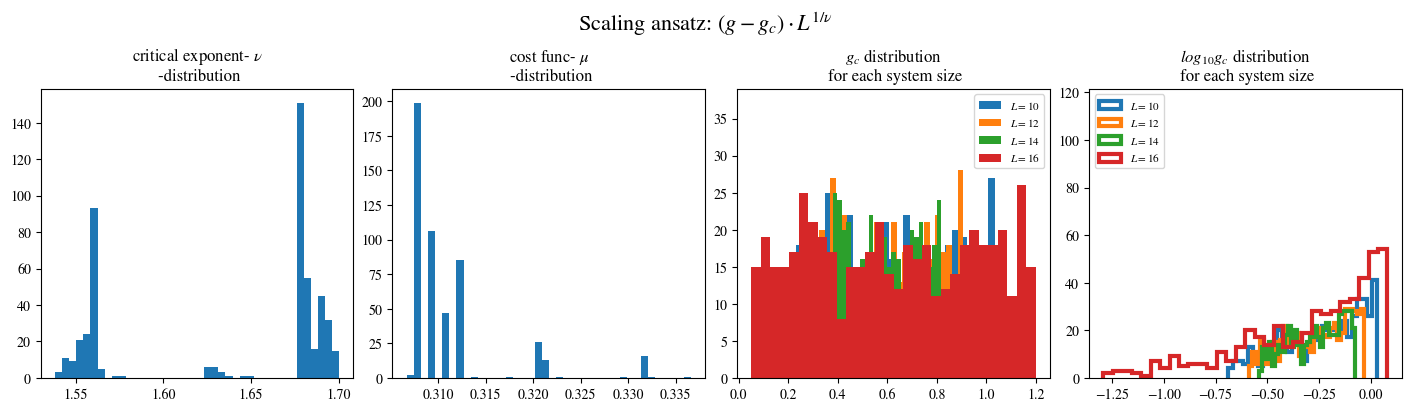

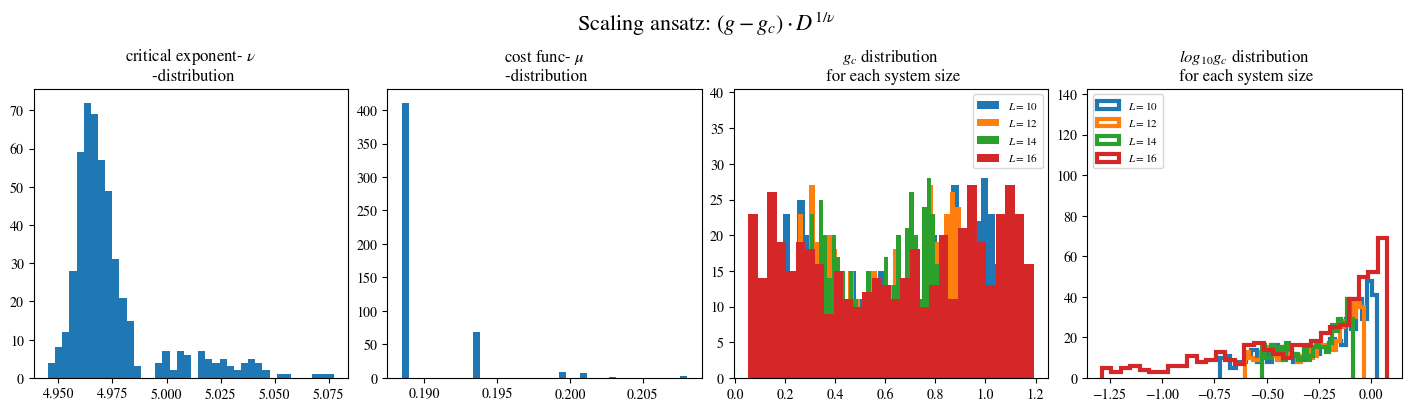

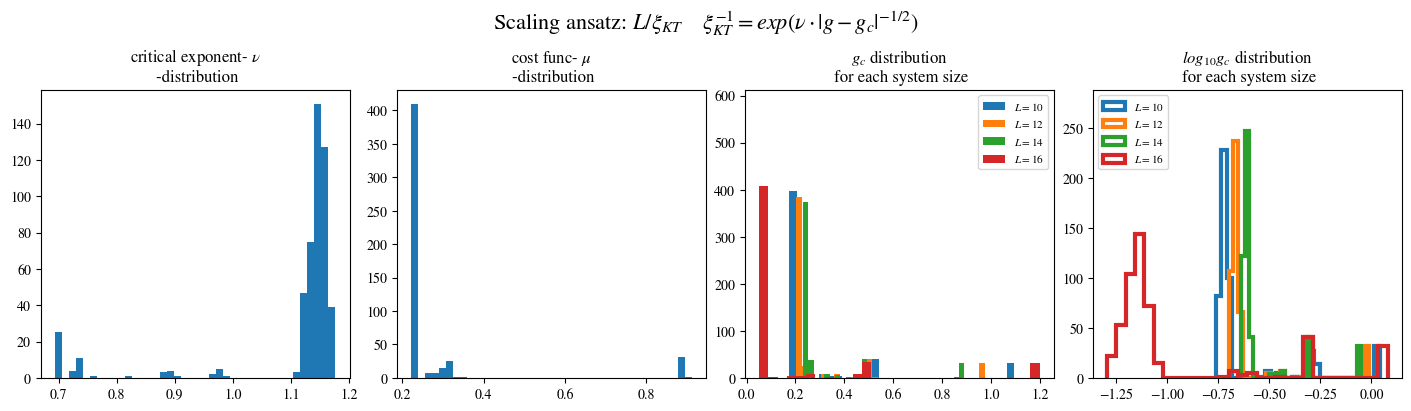

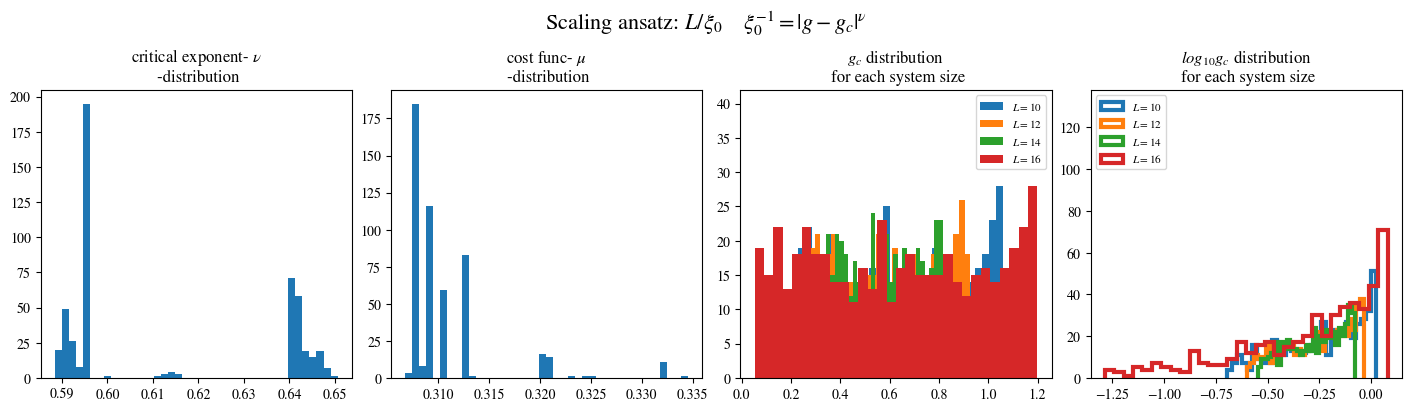

In [9]:
W=10.0

plot_dist(scaling_ansatz='classic', crit_fun='free', W=W)
plot_dist(scaling_ansatz='FGR', crit_fun='free', W=W)
plot_dist(scaling_ansatz='KT', crit_fun='free', W=W)
plot_dist(scaling_ansatz='RG', crit_fun='free', W=W)

10.0
4
10.0
4
10.0
4
10.0
4


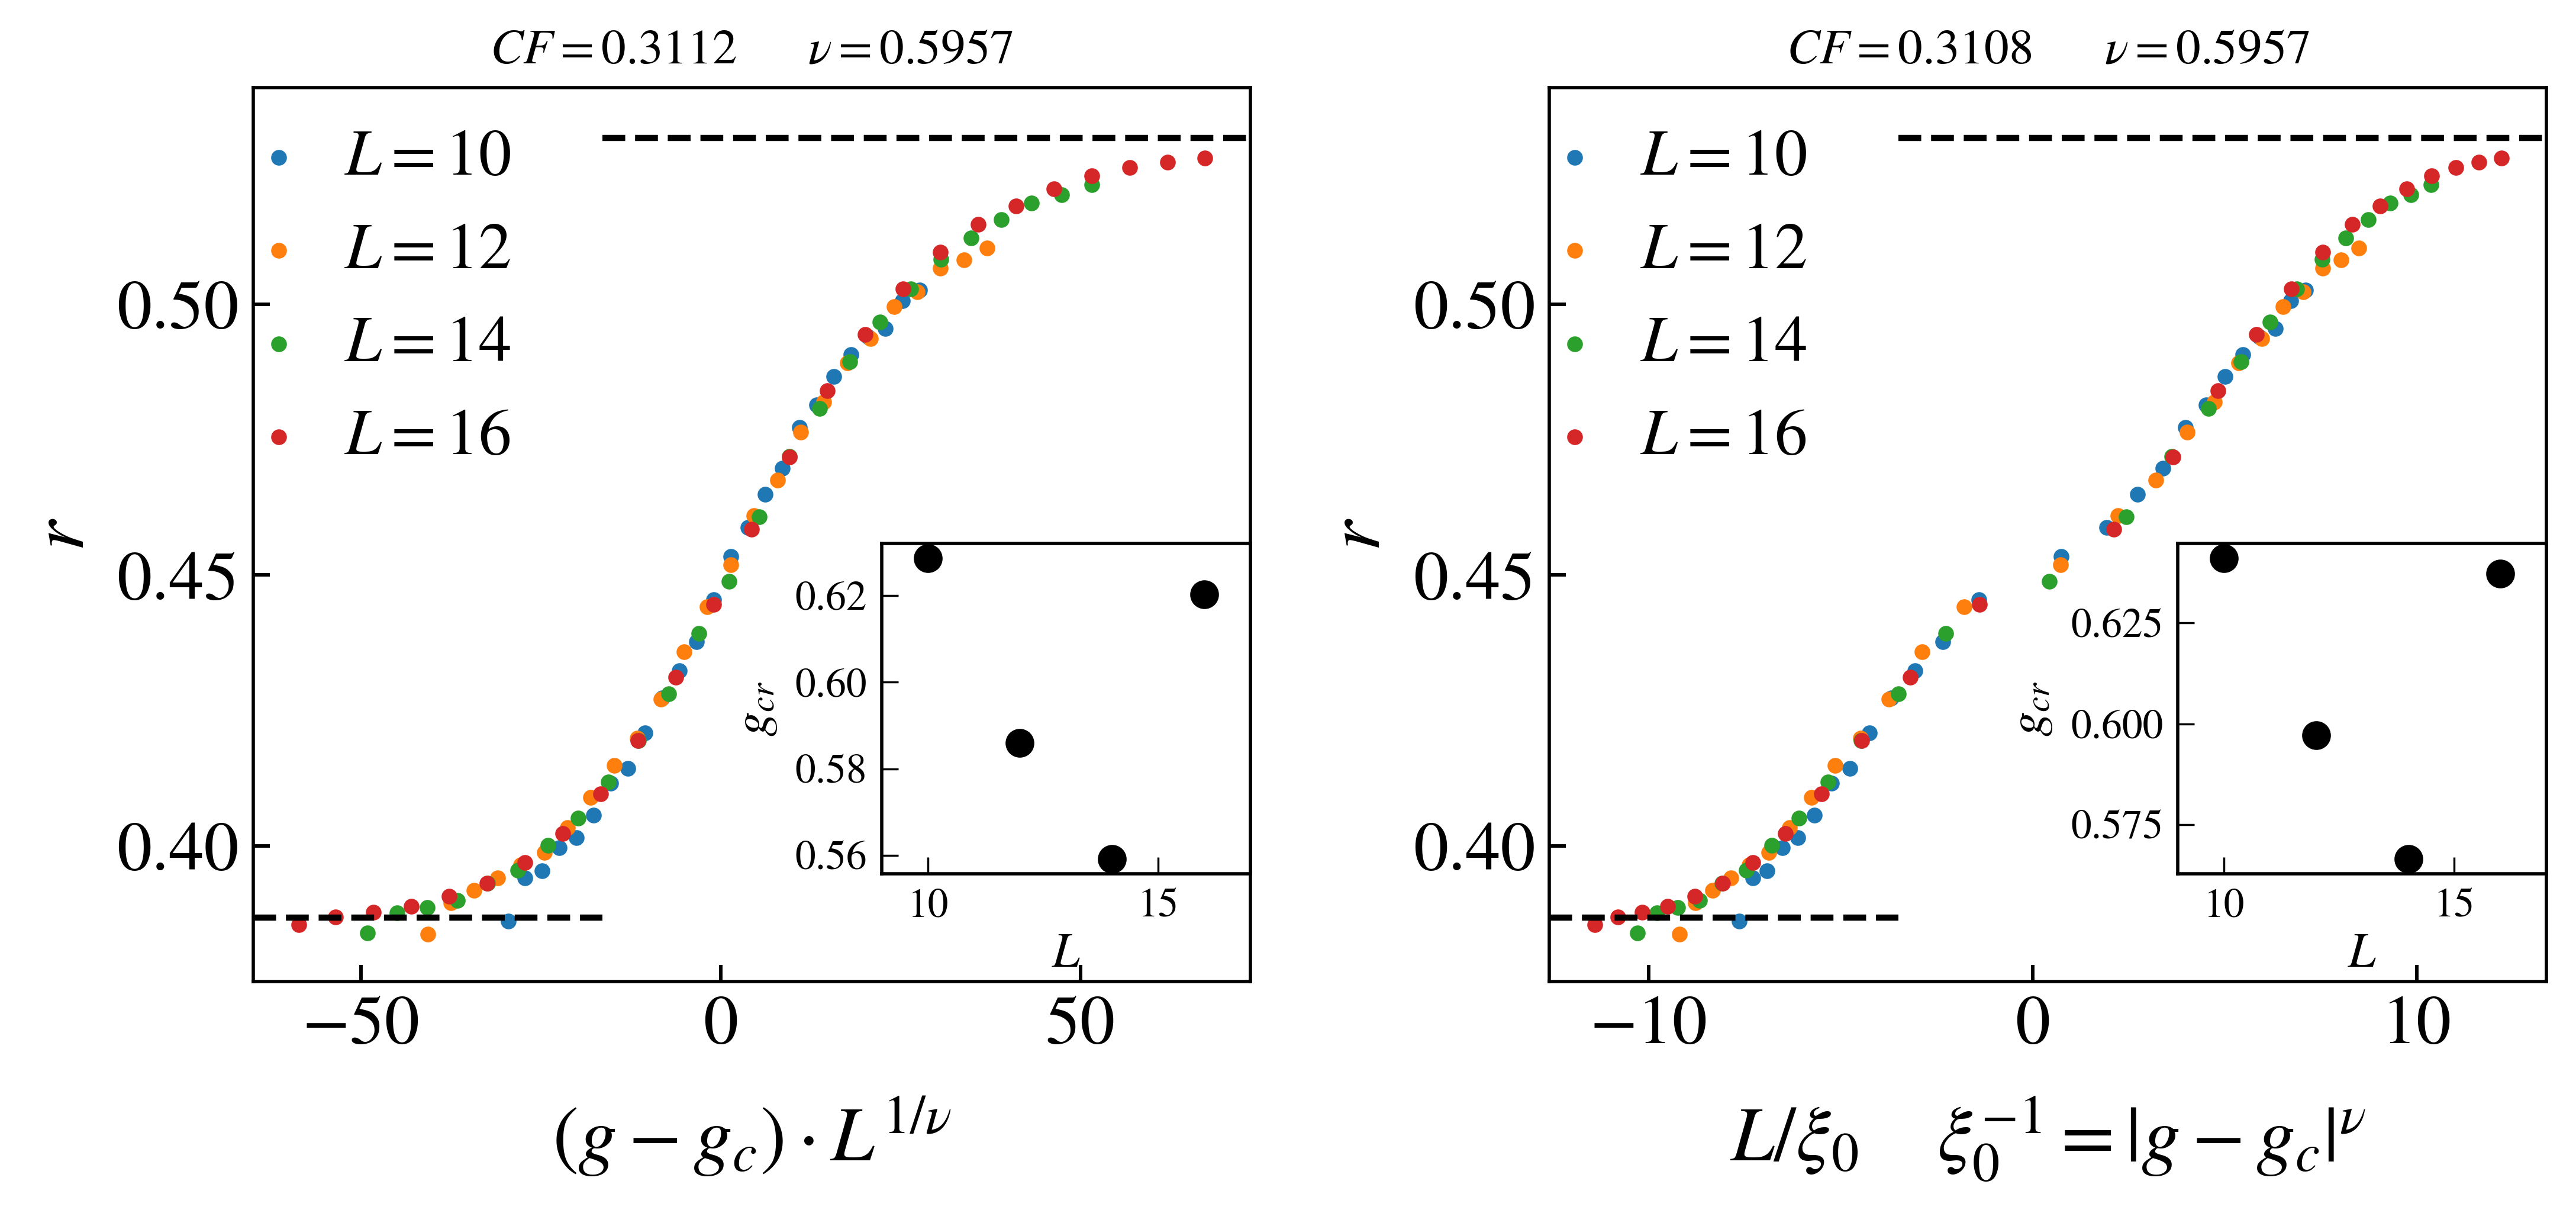

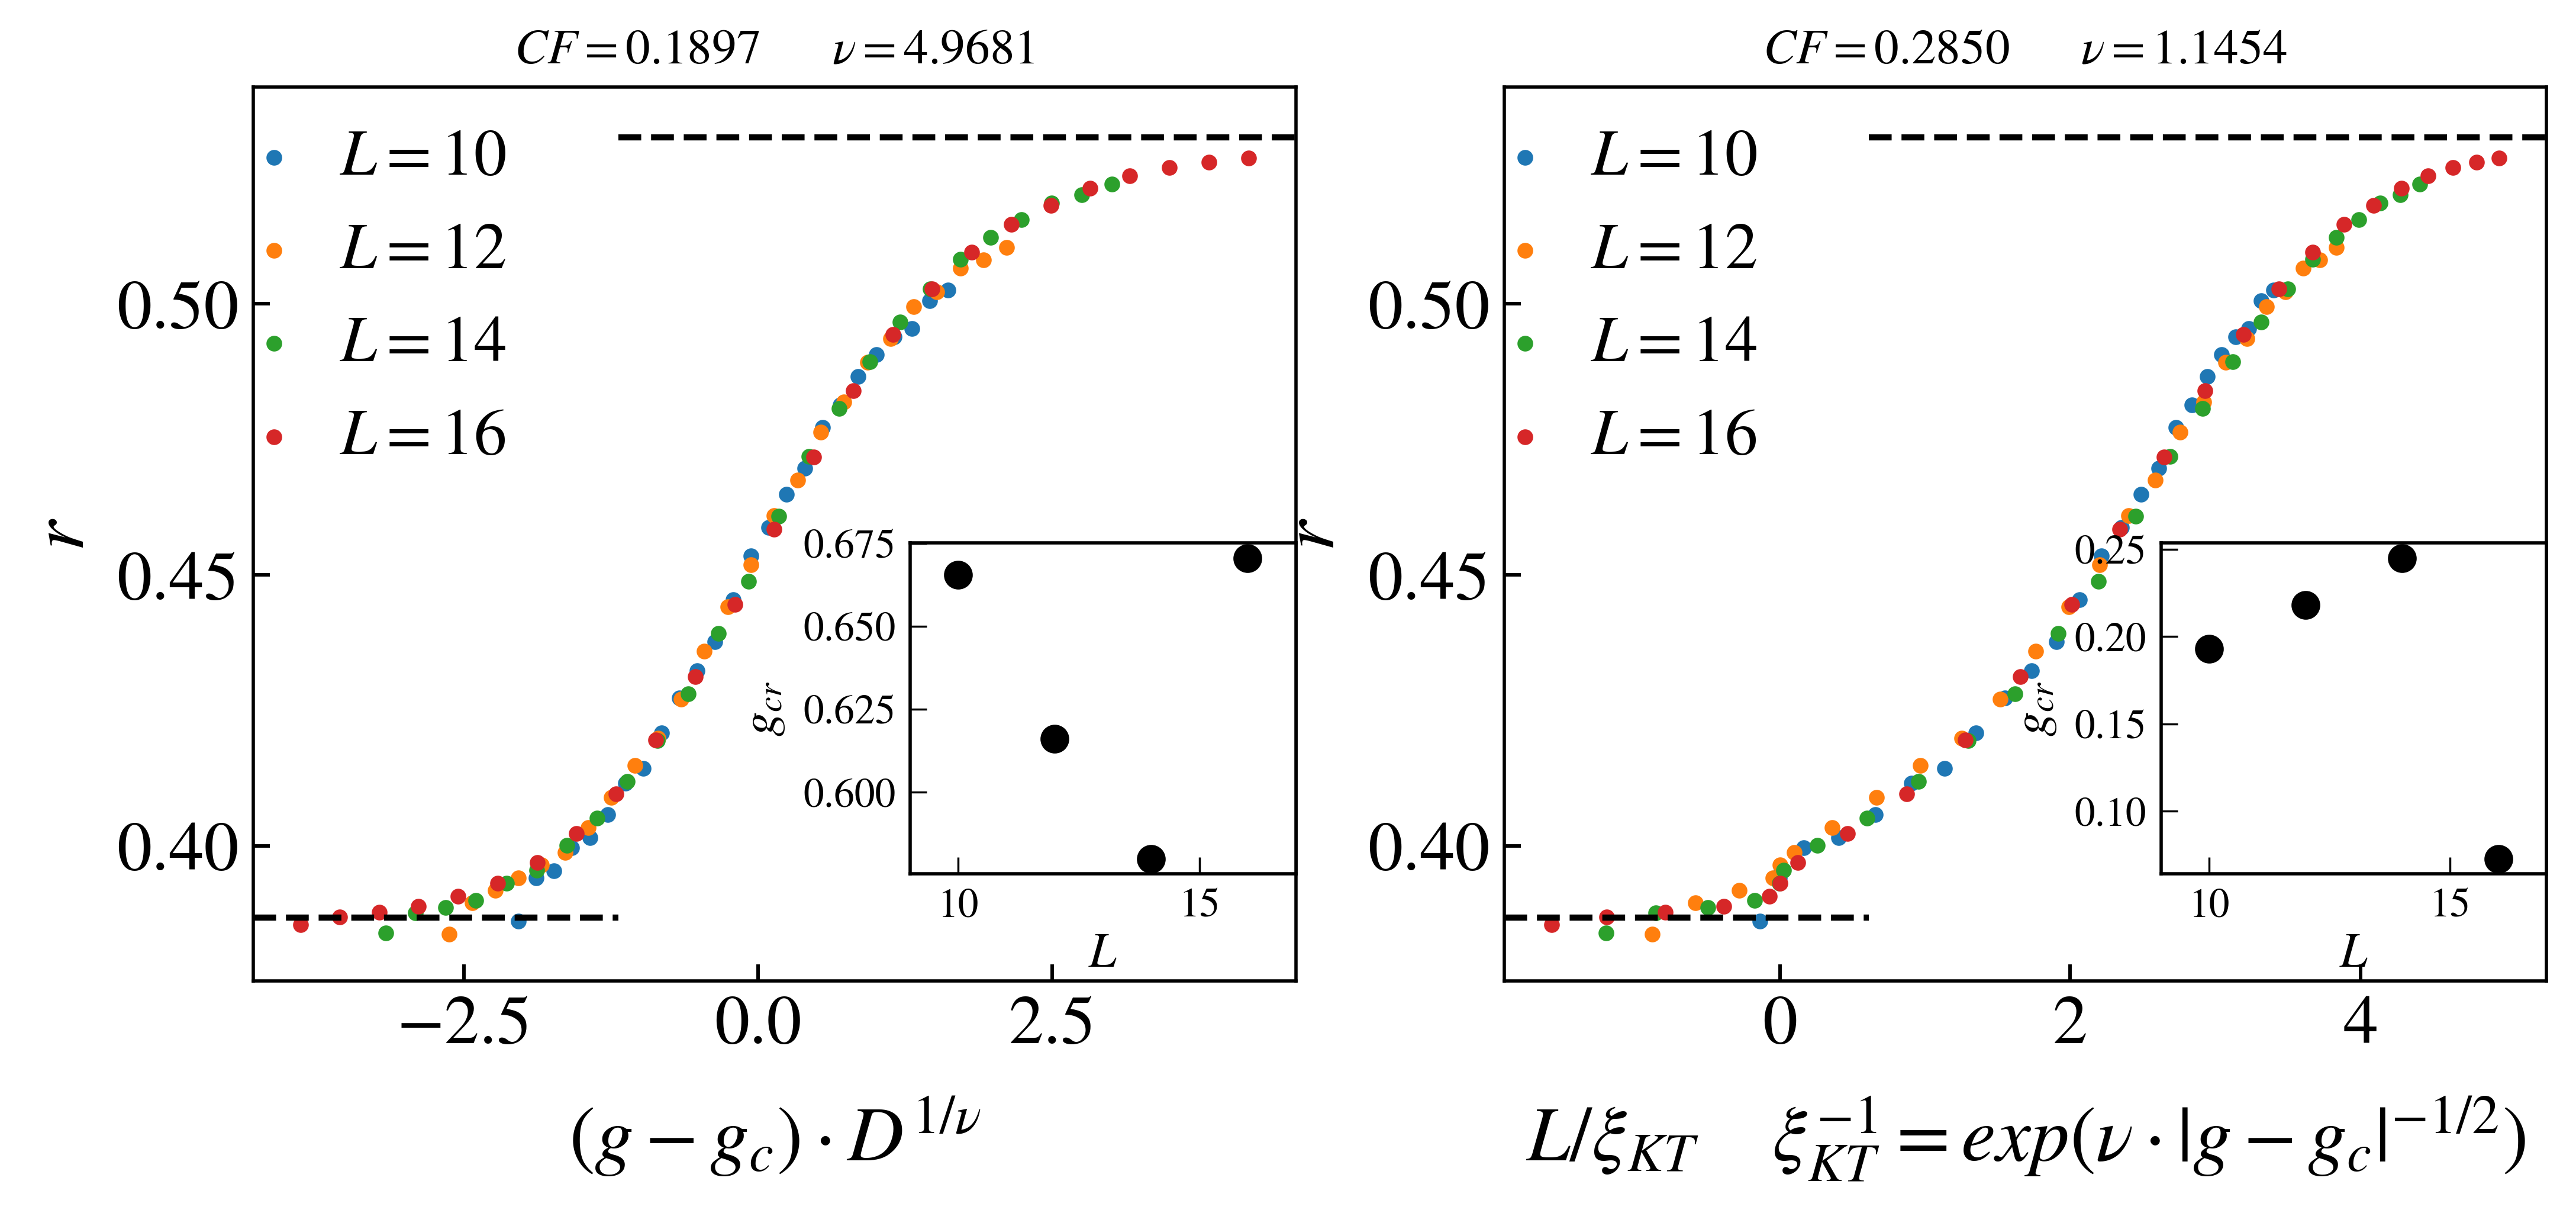

In [10]:
reload_modules()

W = 10.0

fig, (ax1, ax2) = plt.subplots( nrows=1, ncols=2, figsize=(10,4), dpi = 500)
fig.subplots_adjust(wspace=0.3, hspace=0.2)

plot_collapsed_data(axis=ax1, vs = 'g', crit_fun='free', scaling_ansatz='classic', W=W)
plot_collapsed_data(axis=ax2, vs = 'g', crit_fun='free', scaling_ansatz='RG', W=W)

fig, (ax1, ax2) = plt.subplots( nrows=1, ncols=2, figsize=(10,4), dpi = 500)
plot_collapsed_data(axis=ax1, vs = 'g', crit_fun='free', scaling_ansatz='FGR', W=W)
plot_collapsed_data(axis=ax2, vs = 'g', crit_fun='free', scaling_ansatz='KT', W=W)

# ENTROPY TESTS

### SOMETHING

[]
0.09657359027997264


ValueError: max() arg is an empty sequence

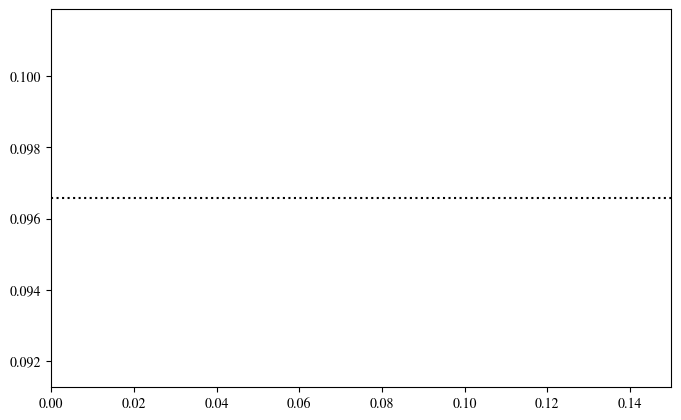

In [ ]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(8,5), dpi = 100)

Smean_ener = []
S_dos = []
S_max_ent = []
validL = []
Smax = []
S_at_Eav = []

f = 1/2

for L in range(8, 19, 1):    
    info = hfun.info_sym(L, J, g, h, k, p, x) if SYMMETRIES else hfun.info_dis(L, J, J0, g, g0, h, w)
    info = dir + info[0 : info.index('.dat') :]
    
    filename = info + "_subsize=%d_jobid=0.hdf5"%(f * L)
    if exists(filename) and abs(int(f * L) - f * L) < 0.01:
        data = []
        with h5py.File(filename, "r") as file:
            # Print all root level object names (aka keys) 
            # these can be group or dataset names 
            print(filename, "Keys: %s" % file.keys())
            energies = np.array(file.get('energies')[0])
            entropy = np.array(file.get('entropy')[0])
        
        
        entropy_smoothed = hfun.remove_fluctuations(entropy, bucket_size=10)
        entropy_smoothed2 = savgol_filter(entropy, window_length=15, polyorder=5, mode="nearest")
        size = energies.size

        # get mean energy
        def get_S(idx):
            num = 500 if L > 8 else 100
            num = 0.5 * size
            my_min = int(idx - num / 2);    
            if my_min < 0: my_min = 0
            my_max = int(idx + num / 2);    
            if my_max>= size: my_max = size

            print(size, my_min, my_max, idx)
            sample = entropy[my_min : my_max]
            return np.mean(sample)

        E_av = np.sum(energies) / size
        idx = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
        Smean_ener.append(get_S(idx))
        S_at_Eav.append(entropy[idx])

        E_av = np.mean(energies)
        idx = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
        S_dos.append(get_S(idx))
        
        E_av = max(entropy)
        idx = min(range(len(entropy)), key=lambda i: abs(entropy[i] - E_av))
        S_max_ent.append(get_S(idx))

        Smax.append(max(entropy))
        
        validL.append(L)

validL = np.array(validL)
def plot_with_fit(axis, sizes, entropy, label = "oh"):
    ydata = np.abs(entropy - page(L=sizes, f=f))

    p = axis.plot(1. / sizes, ydata, marker='o', label=label)
    #pars, sth = fit(f=power_law, 
    #                    xdata=1./sizes, 
    #                    ydata=ydata)
    #
    #Ls = np.linspace(0, 0.2, 100)
    #axis.plot(Ls, power_law(Ls, *pars), linestyle='--', color=p[0].get_color())

plot_with_fit(axis=ax, sizes=validL, entropy=S_dos, label=r"$\langle S \rangle_{E_{max\ DOS}\pm\delta}$")
plot_with_fit(axis=ax, sizes=validL, entropy=Smean_ener, label=r"$\langle S\rangle_{\epsilon\in E_{av}\pm\delta}$")
plot_with_fit(axis=ax, sizes=validL, entropy=S_max_ent, label=r"$\langle S\rangle_{\epsilon\in E_{max\ S}\pm\delta}$")
plot_with_fit(axis=ax, sizes=validL, entropy=Smax, label=r"$\max(S)$")
#plot_with_fit(axis=ax, sizes=validL, entropy=S_at_Eav, label=r"$S(E_{av})$")
print(Smax)
ax.axhline(y = -(f + np.log(1-f)) / 2, linestyle=':', color='black', label="limit for f = %.2f"%f)
print( -(f + np.log(1-f)) / 2)
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(0,0.15)
arr = [S_dos, Smean_ener, S_max_ent, Smax]
arr = [max(np.abs(page(L=(validL), f=f) - x)) for x in arr]
arr.append(-(f + np.log(1-f)) / 2)
ax.set_ylim(0, 1.1 * max(arr))

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

hfun.set_plot_elements(axis = ax, ylabel = "|S_{page} - S|", xlabel = "1\ / \ L", settings=user_settings, 
                            font_size=14, set_legend=True, xlim=(None, None), ylim=(None, None))

ax.legend(frameon=True, ncol=1
                , loc='center left', bbox_to_anchor=(1, 0.5)
                , fontsize=14)
ax.set_xscale('linear');    ax.set_yscale('linear')

sizes = np.array([6, 8, 10, 12, 14, 16])
ax.set_xticks(1. / sizes)
ax.set_xticklabels([r"$\frac{1}{%d}$"%x for x in sizes])
ax.xaxis.set_minor_locator(plt.FixedLocator(1. / (sizes - 1)))

### SIZE SCALING

In [ ]:
def reduced_density_matrix(state, A_size, L):
        dimA = (( (2 **      A_size ) ));
        dimB = (( (2 ** (L - A_size)) ));
        N = dimA * dimB;
        rho = np.zeros((dimA, dimA))
        for n in range(0, N, 1):					
            counter = 0;
            for m in range(n % dimB, N, dimB):
                idx = n // dimB;
                rho[idx, counter] += np.conj(state[n]) * state[m]
                counter+=1
        return rho

L = 10

arr = np.array([1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8])
full_mat = np.outer(arr, arr.T)
print(full_mat)
full_mat=full_mat.reshape([2**(L/2), 2**(L/2), 2**(L/2), 2**(L/2)]);

red_mat = np.trace(full_mat, 0, 3)
print(red_mat)

red_mat = reduced_density_matrix(arr, 2, 4)
print(red_mat)

print(arr.reshape(4, 4))

[[ 1  2  3  4  5  6  7  8  1  2  3  4  5  6  7  8]
 [ 2  4  6  8 10 12 14 16  2  4  6  8 10 12 14 16]
 [ 3  6  9 12 15 18 21 24  3  6  9 12 15 18 21 24]
 [ 4  8 12 16 20 24 28 32  4  8 12 16 20 24 28 32]
 [ 5 10 15 20 25 30 35 40  5 10 15 20 25 30 35 40]
 [ 6 12 18 24 30 36 42 48  6 12 18 24 30 36 42 48]
 [ 7 14 21 28 35 42 49 56  7 14 21 28 35 42 49 56]
 [ 8 16 24 32 40 48 56 64  8 16 24 32 40 48 56 64]
 [ 1  2  3  4  5  6  7  8  1  2  3  4  5  6  7  8]
 [ 2  4  6  8 10 12 14 16  2  4  6  8 10 12 14 16]
 [ 3  6  9 12 15 18 21 24  3  6  9 12 15 18 21 24]
 [ 4  8 12 16 20 24 28 32  4  8 12 16 20 24 28 32]
 [ 5 10 15 20 25 30 35 40  5 10 15 20 25 30 35 40]
 [ 6 12 18 24 30 36 42 48  6 12 18 24 30 36 42 48]
 [ 7 14 21 28 35 42 49 56  7 14 21 28 35 42 49 56]
 [ 8 16 24 32 40 48 56 64  8 16 24 32 40 48 56 64]]
[[ 30  70  30  70]
 [ 70 174  70 174]
 [ 30  70  30  70]
 [ 70 174  70 174]]
[[ 30.  70.  30.  70.]
 [ 70. 174.  70. 174.]
 [ 30.  70.  30.  70.]
 [ 70. 174.  70. 174.]]
[[1 2 3 4]
 [

In [ ]:
def find_index(map, index):
    idx=-1
    try:
        idx = list(map).index(index)
    except Exception:
        idx=-1
    return idx

def reduced_density_matrix_nonormal(state, A_size, L, map):
        dimA = int(( (2 **      A_size ) ));
        dimB = int(( (2 ** (L - A_size)) ));
        N = int(len(map))
        rho = np.zeros((dimA, dimA))
        for n in range(0, N, 1):					
            counter = 0;
            tru_n = map[n]
            for m in range(tru_n % dimB, dimA * dimB, dimB):
                idx = tru_n // dimB;
                tru_m = find_index(map, m)
                if tru_m >= 0:
                    rho[idx, counter] += np.conj(state[n]) * state[tru_m]
                counter += 1
        return rho
L=10
dim = int(2**(L/2))
with h5py.File("map.hdf5", "r") as file:
    map = np.array(file.get('map')[0]).astype(int)
    print(map.shape)

with h5py.File("state.hdf5", "r") as file:
    state = np.array(file.get('state')[0]).astype(float)
    print(state.shape)
    if len(map) > 0:
        arr = np.zeros((2**L))
        for i, m in enumerate(map):
            arr[m] = state[i]
    else:
        arr = state


full_mat = np.outer(arr, arr.T)
full_mat=full_mat.reshape([dim, dim, dim, dim]);

red_mat = np.trace(full_mat, 0, 2)
print("PYTHON:\n", -np.trace(red_mat * np.log(red_mat)))

red_mat = reduced_density_matrix(arr, int(L/2), L)
print("C++ Full:\n", -np.trace(red_mat * np.log(red_mat)))

red_mat = arr.reshape((dim, dim))

U, s, V = np.linalg.svd(red_mat, full_matrices=False)
print(np.sum(s**2))
print("Jan:\n", -np.sum(s**2 * np.log(s**2)))

red_mat = reduced_density_matrix_nonormal(state, int(L/2), L, map)
eigs = np.linalg.eigvals(red_mat)
S = -np.sum(eigs * np.log(eigs))
print("C++:\n", S)




(252,)
(252,)
PYTHON:
 nan
C++ Full:
 3.032771391309905
0.9999999999999994
Jan:
 1.8696700245916809
C++:
 1.869670024591681


# HEISENBERG RESULTS

_L=*,J=1.00,J0=0.00,g=*,g0=0.00,h=0.00,w=0.70_subsize=*_jobid=*.hdf5
[10, 12, 14, 16, 18]
[5.8e-04 7.6e-04 8.7e-04 1.0e-03 1.1e-03 1.3e-03 1.5e-03 1.7e-03 2.0e-03
 2.3e-03 2.6e-03 3.0e-03 3.5e-03 4.0e-03 4.6e-03 5.3e-03 6.0e-03 6.9e-03
 7.9e-03 9.1e-03 1.0e-02 1.2e-02 1.4e-02 1.6e-02 1.8e-02 2.0e-02 2.1e-02
 2.4e-02 2.8e-02 3.2e-02 3.6e-02 4.0e-02 4.2e-02 4.8e-02 5.5e-02 6.0e-02
 6.3e-02 7.2e-02 8.0e-02 8.3e-02 9.6e-02 1.0e-01 1.1e-01 1.2e-01 1.3e-01
 1.4e-01 1.6e-01 1.7e-01 1.8e-01 1.9e-01 2.0e-01 2.2e-01 2.4e-01 2.5e-01
 2.6e-01 2.8e-01 2.9e-01 3.0e-01 3.2e-01 3.3e-01 3.4e-01 3.6e-01 3.8e-01
 4.0e-01 4.2e-01 4.4e-01 4.6e-01 4.8e-01 5.0e-01 5.2e-01 5.4e-01 5.5e-01
 5.6e-01 5.8e-01 6.0e-01 6.2e-01 6.4e-01 6.6e-01 6.8e-01 7.0e-01 7.2e-01
 7.4e-01 7.6e-01 7.8e-01 8.0e-01 8.2e-01 8.4e-01 8.6e-01 8.7e-01 8.8e-01
 9.0e-01 9.2e-01 9.4e-01 9.6e-01 9.8e-01 1.0e+00]
[   0    1    2    3    4    6   30   32   33   34   35   36   37   38
   39  100  200  300  400  500  600  700  800  900 1000 110

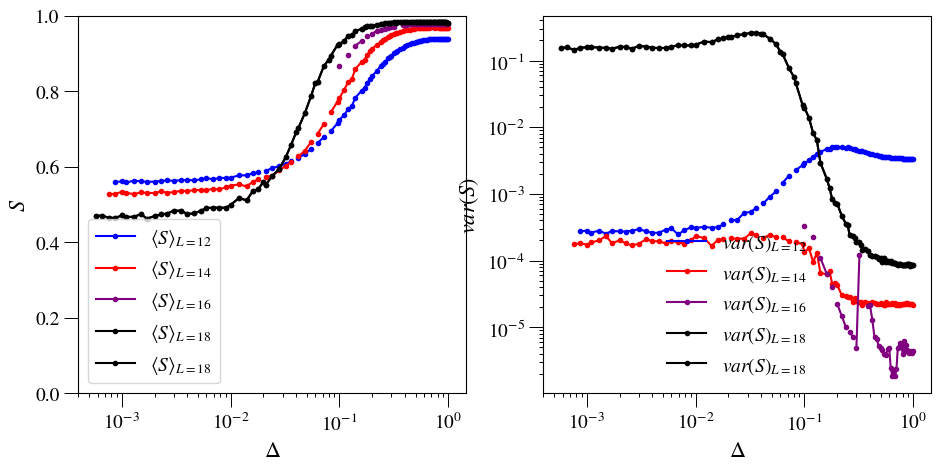

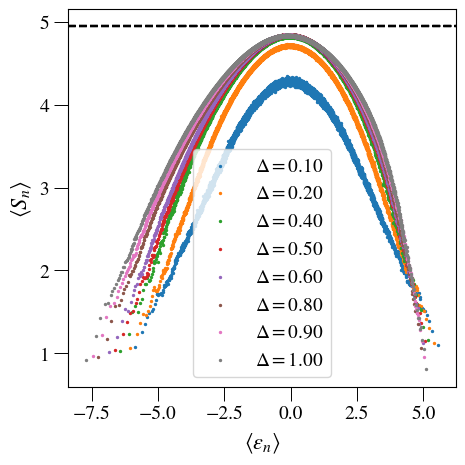

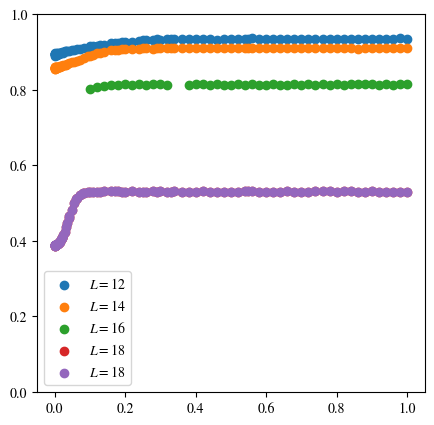

In [ ]:
reload_modules()

from fnmatch import fnmatch as fn
dir_in = f"{cf.base_directory}Entropy{os.sep}Eigenstate{os.sep}raw_data{os.sep}"
dir_out = f"{cf.base_directory}Entropy{os.sep}Eigenstate{os.sep}"


set_class = copy.deepcopy(cf.plot_settings)
set_class.set_scaling('g')
set_class.set_vs('x')
settings = getattr(set_class, 'settings')

SINGLE_REALISATION = 0

ii = settings['scaling_idx']
info = ""
# ASSUMING DISORDER MODULE FOR NOW
arr = [cf.J, cf.J0, cf.g, cf.g0, cf.h, cf.w]
names = ['J', 'J0', 'g', 'g0', 'h', 'w']
indices = [-1, 0, 2, 4, 5]
def create_info(use_log_data = True):
    info = "_L=*"
    for i, var in enumerate(arr):
        n = hfun.order_of_magnitude(var) if use_log_data else 2
        if i == indices[ii]:
            info += ",%s=*"%names[i]
        else: info += str(",%s={:.%df}"%(names[i], n)).format(round(var, n))
    return info + "_subsize=*_jobid=*.hdf5"
info = create_info()
print(info)

sizes = []
collected_pars = []
realis = []
#--------------------------------------- COLLECT DATA
def append_parameter_range(filename):
    if fn(filename, info):
        bare_info, extension = os.path.splitext(filename)
        
        f = os.path.join(dir_in, filename)
        if os.path.isfile(f):
            pars = hfun.get_params_from_info(bare_info)
            
            if pars[ii] not in collected_pars:  collected_pars.append(pars[ii])
            if pars[0] not in sizes:            sizes.append(int(pars[0]))
            if pars[-1] not in realis:          realis.append(int(pars[-1]))

for filename in os.listdir(dir_in): 
    info = create_info()
    append_parameter_range(filename)
    info = create_info(False)
    append_parameter_range(filename)

pars = cf.params_arr
sizes = list(np.sort(sizes))
collected_pars = np.sort(collected_pars)
realis = np.sort(realis)
print(sizes)
print(collected_pars)
print(realis)
lab = hfun.var_name if settings['scaling_idx'] == 2 else settings['scaling']
vals = hfun.get_scaling_array(settings, x0=0.1, xend=1.0, dx=0.1)

sizes = sizes if ii != 0 else [0];
entropy = []
colors = {
    10: 'green',
    12: 'blue', 
    14: 'red',
    16: 'purple', 
    18: 'black'
    }
fig, (ax, axis) = plt.subplots( nrows=1, ncols=2, figsize=(11,5), dpi = 100)
fig, ax2 = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 100)
fig, ax3 = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 100)


param_copy = copy.deepcopy(cf.params_arr)
sizes.append(18);   sizes = np.array(sizes)

for L in sizes[1:]:
    new_pars = pars
    if ii != 0:
        new_pars[0] = L

    info_out = dir_out + hfun.remove_info(hfun.info_param(new_pars), settings['scaling']) + "_subsize=%d.hdf5"%(L/2)
    S = []
    i = 0
    Smax = []
    Svar = []

    x = []
    gaps = []
    if L == 18:
        cf.params_arr[settings['scaling_idx']] = L
        filename = cf.base_directory + "STATISTICS" + os.sep + hfun.remove_info(hfun.info_param(cf.params_arr), settings['scaling']) + ".dat" 
        if os.path.exists(filename):
            stats = hfun.read_python_saved_dat_file(filename)
            
            x = stats[0]
            gaps = stats[1]
            S = stats[4]
            Smax = [np.nan for i in range(x.size)]
            Svar = stats[7]
    else:
        x = collected_pars

        for par in collected_pars:
            new_pars[ii] = par
            info_in = hfun.info_param(new_pars)
            base_info, ext = os.path.splitext(info_in)

            info_in = base_info + "_subsize=%d"%(L/2) + "_jobid=%d.hdf5"%realis[0]
            if SINGLE_REALISATION:
                info_in = "realisation=%d"%0 + os.sep + base_info + "_subsize=%d"%(L/2) + ".hdf5"
            ener = [0 for i in range(int(binom(L, int(L/2))))]
            ent = [0 for i in range( int(binom(L, int(L/2))))]
            counter = 0.0
            Sall = []
            rall = 0
            for r in (realis  if SINGLE_REALISATION == 0 else [0]):
                info_in = base_info + "_subsize=%d"%(L/2) + "_jobid=%d.hdf5"%r
                if os.path.exists(dir_in + info_in):
                    with h5py.File(dir_in + info_in, "r") as f:
                        # Print all root level object names (aka keys) 
                        # these can be group or dataset names
                        E = np.array(f.get('energies')[0])
                        ener += E
                        ent += np.array(f.get('entropy')[0])
                        counter += 1.0
                        r=0;
                        cunt = 0
                        for i in range(E.size):
                            if i > int(0.25 * E.size) and i < int(0.75 * E.size):
                                gap1 = E[i] - E[i - 1];
                                gap2 = E[i + 1] - E[i];
                                if gap1 <= 1e-15:
                                    print("Degeneracy", E[i-5 : i+5])
                                r += min(gap1, gap2) / max(gap1, gap2)
                                cunt += 1.0
                        r /= cunt
                        rall += r
            if counter > 0:
                gaps.append(rall / counter)
            else:
                gaps.append(np.nan)

            ener = np.array(ener) / counter
            ent = np.array(ent) / counter



            if par in vals and L == 16 and max(ent) > 1e-2:
                norm = L * np.log(2) / 2. + (0.5 - np.log(2)) / 2. - 0.5
                ax2.axhline(y=norm, linestyle='--', color='black')
                ax2.scatter(ener, ent, label=r"$%s=%.2f$"%(lab, par), s=2)

            idx_min = int(0.5 * ent.size) - 250
            idx_max = int(0.5 * ent.size) + 250  
            ent = ent[idx_min : idx_max]
            S.append(np.mean(ent))
            Smax.append(max(ent))
            Svar.append(np.var(ent))

    Smax = np.array(Smax)        
    norm = L * np.log(2) / 2. + (0.5 - np.log(2)) / 2. - 0.5 
    ax.plot(x, S / norm, label=r"$\langle S\rangle_{L=%d}$"%L, marker = 'o', markersize=3, color=colors[L])
    #ax.scatter(x, Smax / norm, marker='s', edgecolor=colors[L], facecolor='None', label=r"$S^{max}_{L=%d}$"%L,s=8)  
    ax3.scatter(x, gaps, label=r"$L=%d$"%L)
    ax3.set_ylim(0., 1.)
    axis.plot(x, Svar, marker = 'o', markersize=3, color=colors[L], label=r"$var(S)_{L=%d}$"%L)    

    entropy.append(np.array(S))  

cf.params_arr = param_copy
hfun.set_plot_elements(axis = ax, ylabel = "S", xlabel = lab, settings=settings, 
                            font_size=14, set_legend=True, xlim=(None, None), ylim=(None, None))
hfun.set_plot_elements(axis = axis, ylabel = "var(S)", xlabel = lab, settings=settings, 
                            font_size=14, set_legend=True, xlim=(None, None), ylim=(None, None))

ax.legend(frameon=True, ncol=1
                , loc='best'
                , fontsize=14)
ax.set_xscale('log');    ax.set_yscale('linear')
ax.set_ylim(0,1)
hfun.set_plot_elements(axis = ax2, xlabel = "\\langle \\epsilon_n\\rangle", ylabel = "\\langle S_n\\rangle", settings=settings, 
                            font_size=14, set_legend=False, xlim=(None, None), ylim=(None, None))
ax2.legend(frameon=True, ncol=1
                , loc='best'
                , fontsize=14)
ax2.set_xscale('linear');    ax2.set_yscale('linear')
fig.subplots_adjust(wspace=0.4, hspace=0.2)

ax3.legend()


# HEISENBERG MULTIFRACTALITY

../results/HEISENBERG/disorder/PBC/MultiFractality/ParticipationRatio/_L=8,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.10_q=0.80_jobid=0.hdf5
70
../results/HEISENBERG/disorder/PBC/MultiFractality/ParticipationRatio/_L=10,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.10_q=0.80_jobid=0.hdf5
252
../results/HEISENBERG/disorder/PBC/MultiFractality/ParticipationRatio/_L=12,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.10_q=0.80_jobid=0.hdf5
924
../results/HEISENBERG/disorder/PBC/MultiFractality/ParticipationRatio/_L=14,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.10_q=0.80_jobid=0.hdf5
3432
../results/HEISENBERG/disorder/PBC/MultiFractality/ParticipationRatio/_L=16,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.10_q=0.80_jobid=0.hdf5
12870
../results/HEISENBERG/disorder/PBC/MultiFractality/ParticipationRatio/_L=18,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.10_q=0.80_jobid=0.hdf5
48620


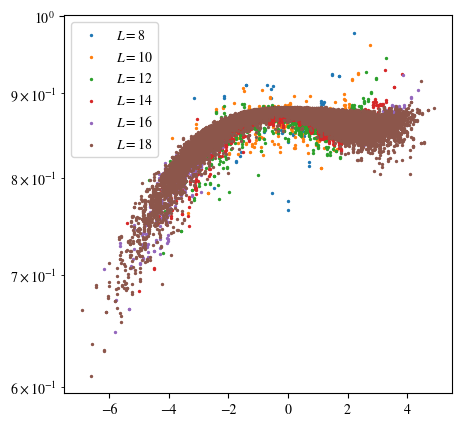

In [ ]:
reload_modules()
cf.params_arr[4] = 0.1
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 100)

sizes = range(8, 19, 2)
q = 0.8

use_single_realisation = False
dirr = cf.base_directory + "MultiFractality" + kPSep + "ParticipationRatio" + kPSep
if use_single_realisation and cf.model != 2: dirr += "realisation=0" + kPSep
    
for L in sizes:
    cf.params_arr[0] = L
    filename = dirr + hfun.remove_info(hfun.info_param(cf.params_arr), 'x') + "_q=%.2f"%(q) + (".hdf5" if use_single_realisation else "_jobid=0.hdf5")
    print(filename)
    if exists(filename):
        with h5py.File(filename, "r") as f:
            # Print all root level object names (aka keys) 
            # these can be group or dataset names
            E = np.array(f.get('energies')[0])
            pr = np.array(f.get('entropy')[0])
            print(E.size)
            ax.scatter(E, pr * E.size**(1 * (q-1)), label=r"$L=%d$"%L, s=2)

ax.legend()
ax.set_yscale('log')

[ 8. 10. 12. 14. 16. 18.] [0.285661   0.312658   0.44355007 0.51107578 0.53002417 0.53106689]
[ 8. 10. 12. 14. 16. 18.] [0.366261   0.455671   0.51692118 0.5306832  0.5302577  0.53064207]
[ 8. 10. 12. 14. 16. 18.] [0.44355    0.505296   0.52863353 0.5308041  0.53048253 0.53026592]
[ 8. 10. 12. 14. 16. 18.] [0.482113   0.522504   0.52996047 0.53090065 0.53100645 0.53031497]
[ 8. 10. 12. 14. 16. 18.] [0.492043   0.524923   0.5300932  0.5311403  0.5307885  0.53061226]
[ 8. 10. 12. 14. 16. 18.] [0.496535   0.53086    0.5305469  0.53117295 0.53078955 0.53038233]
[ 8. 10. 12. 14. 16. 18.] [0.499136   0.530861   0.5308233  0.53066315 0.53062655 0.53102465]


No handles with labels found to put in legend.


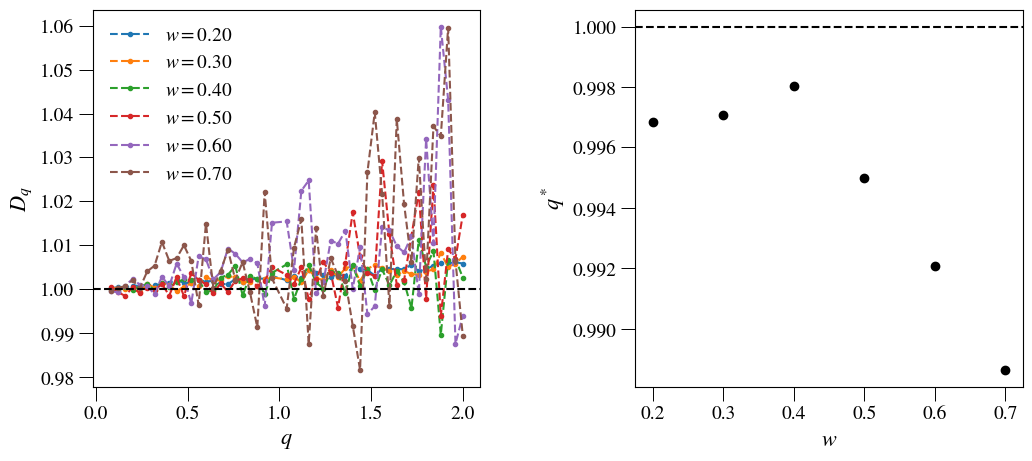

In [ ]:
reload_modules()
fig, (ax, ax2) = plt.subplots( nrows=1, ncols=2, figsize=(12,5), dpi = 100)

vals = hfun.regspace(0.1, 0.8, 0.1)
qs = hfun.regspace(0.04, 2.1, 0.04)
sizes = range(12, 19, 2)

use_single_realisation = True
dirr = cf.base_directory + "MultiFractality" + kPSep + "ParticipationRatio" + kPSep
if use_single_realisation and cf.model != 2: dirr += "realisation=0" + kPSep
    
q_star = []
for w in vals:
    cf.params_arr[4] = w
    qs_plot = []
    tau_q = []
    stats_name = cf.base_directory + "STATISTICS" + kPSep + hfun.remove_info(hfun.info_param(cf.params_arr), 'L') + ".dat" 
    stats = hfun.read_python_saved_dat_file(stats_name)
    gaps = stats[1]
    print(stats[0], gaps)
    for q in qs:
        pr = []
        dims = []
        pr_to_fit = []
        dim_to_fit = []
        for i, L in enumerate(sizes):
            cf.params_arr[0] = L
            filename = dirr + hfun.remove_info(hfun.info_param(cf.params_arr), 'x') + "_q=%.2f"%(q) + (".hdf5" if use_single_realisation else "_jobid=0.hdf5")
            #print(filename)
            if exists(filename):
                with h5py.File(filename, "r") as f:
                    # Print all root level object names (aka keys) 
                    # these can be group or dataset names
                    E = np.array(f.get('energies')[0])
                    dim = E.size

                    E_av = np.mean(E)
                    idx = min(range(len(E)), key=lambda i: abs(E[i] - E_av))
                    mu = 0.5*dim
                    idx_min = int(idx - mu/2) if idx - mu/2 >= 0 else 0
                    idx_max = int(idx + mu/2) if idx + mu/2 < dim else dim
                    pr_tmp = np.array(f.get('entropy')[0])[idx_min : idx_max]

                    pr.append(np.mean(pr_tmp))
                    dims.append(dim)
                    if np.abs(gaps[i] - 0.53) <= 0.03 and L >= 12:
                        pr_to_fit.append(np.mean(pr_tmp))
                        dim_to_fit.append(dim)
                    
        if len(pr_to_fit) > 1:
            pars, pcov = fit(f=power_law, 
                        xdata=dim_to_fit, 
                        ydata=pr_to_fit)
            
            alfa = np.log2(pr_to_fit[-1] / pr_to_fit[0]) / np.log2(dim_to_fit[-1] / dim_to_fit[0])
            alfa = pars[0] 
            tau_q.append(-alfa)
            if q not in qs_plot: qs_plot.append(q)
            
    if len(tau_q) > 0:
        qs_plot = np.array(qs_plot)
        tau_q = np.array(tau_q)
        ax.plot(qs_plot, tau_q / (qs_plot - 1.), label=r"$w=%.2f$"%w, marker='o', markersize=3, linestyle='--')
        
    
        pars, pcov = fit(f=lin_fit2, 
                            xdata=qs_plot, 
                            ydata=tau_q)
        ax2.scatter(w, 1./pars[0], color='black')
        #ax2.scatter(qs_plot, tau_q, label=r"$w=%.2f$"%w, s=3)
        #ax2.plot(qs_plot, lin_fit2(qs_plot, *pars), linestyle='--')
#ax.set_yscale('log')                

hfun.set_plot_elements(axis = ax, xlim = (None, None), ylim = (None, None), ylabel = "r", xlabel = "", settings=user_settings, font_size=14, set_legend=True)
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$D_q$")
ax.axhline(y=1.0, linestyle='--', color='black')
ax.set_xscale('linear')
ax.set_yscale('linear')

hfun.set_plot_elements(axis = ax2, xlim = (None, None), ylim = (None, None), ylabel = "r", xlabel = "", settings=user_settings, font_size=14, set_legend=True)
ax2.set_xlabel(r"$w$")
ax2.set_ylabel(r"$q^*$")
ax2.axhline(y=1.0, linestyle='--', color='black')
ax2.set_xscale('linear')
ax2.set_yscale('linear')
fig.subplots_adjust(wspace=0.4, hspace=0.3)

4
[ 8. 10. 12. 14. 16. 18.] [0.285661   0.312658   0.44355007 0.51107578 0.53002417 0.53106689]
[ 8. 10. 12. 14. 16. 18.] [0.366261   0.455671   0.51692118 0.5306832  0.5302577  0.53064207]
['None', 'None', 'blue', 'blue', 'blue', 'blue']
['None', 'None', 'red', 'red', 'red', 'red']
[ 8. 10. 12. 14. 16. 18.] [0.44355    0.505296   0.52863353 0.5308041  0.53048253 0.53026592]
[ 8. 10. 12. 14. 16. 18.] [0.482113   0.522504   0.52996047 0.53090065 0.53100645 0.53031497]
[ 8. 10. 12. 14. 16. 18.] [0.492043   0.524923   0.5300932  0.5311403  0.5307885  0.53061226]
[ 8. 10. 12. 14. 16. 18.] [0.496535   0.53086    0.5305469  0.53117295 0.53078955 0.53038233]
['None', 'blue', 'blue', 'blue', 'blue', 'blue']
['None', 'red', 'red', 'red', 'red', 'red']
[ 8. 10. 12. 14. 16. 18.] [0.499136   0.530861   0.5308233  0.53066315 0.53062655 0.53102465]


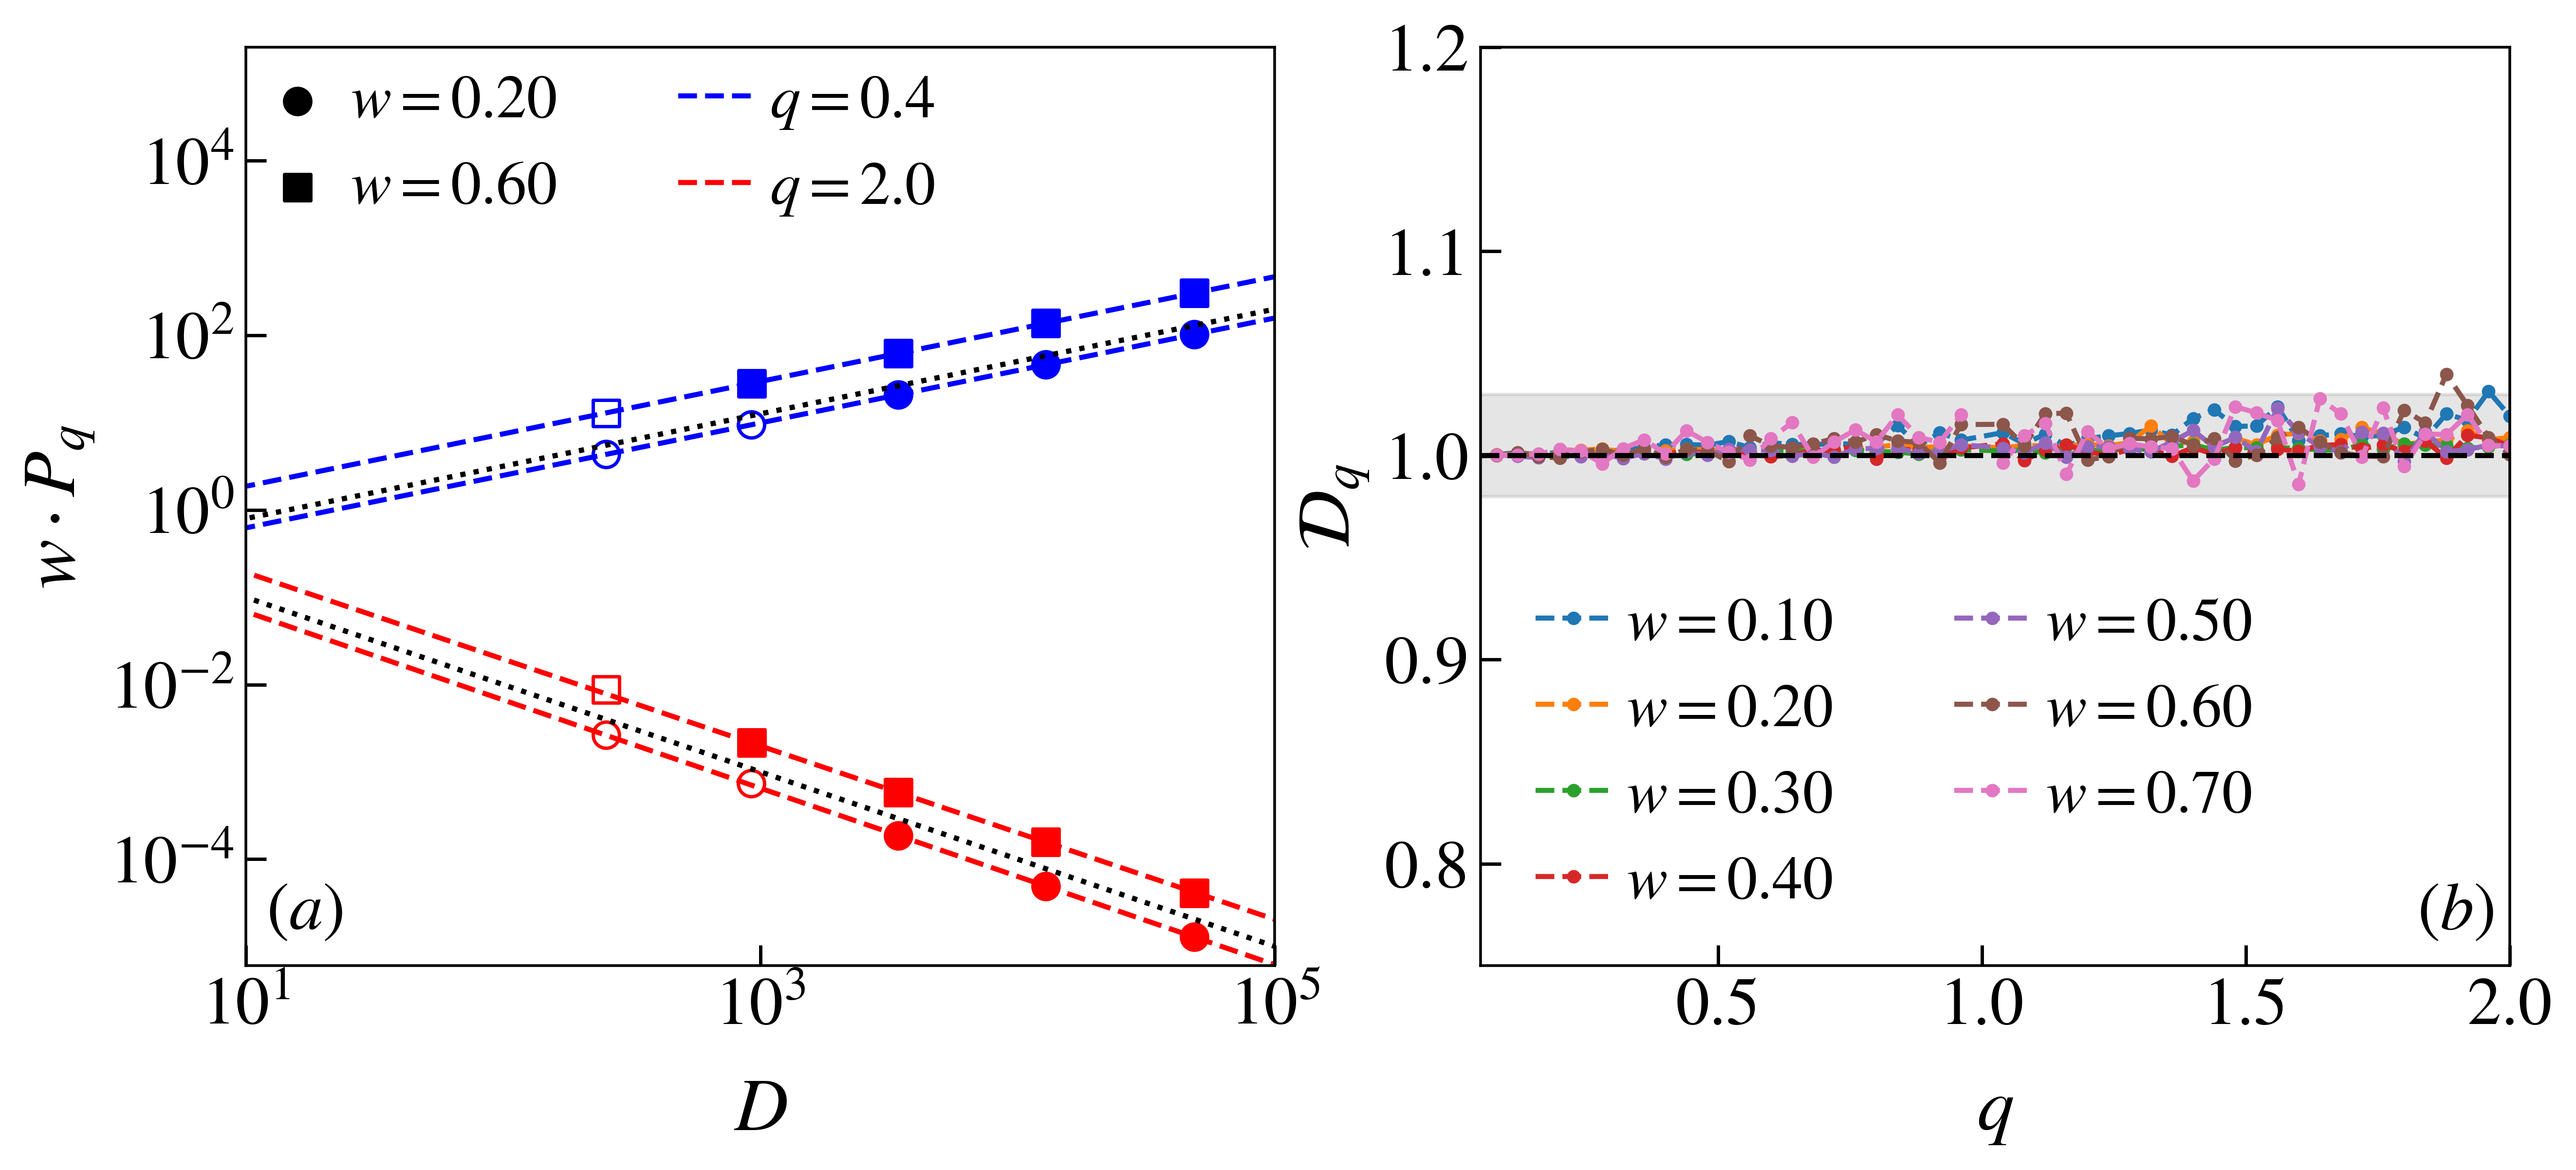

In [ ]:
reload_modules()
fig, (ax, ax2) = plt.subplots( nrows=1, ncols=2, figsize=(12,5), dpi = 500)
user_settings = getattr(cf.plot_settings, 'settings')

vals = hfun.regspace(0.1, 0.8, 0.1)
qs = hfun.regspace(0.04, 2.1, 0.04)
sizes = range(10, 19, 2)

x_to_plot = [0.2, 0.6]
q_to_plot = [0.4, 2.0]

use_single_realisation = True
dirr = cf.base_directory + "MultiFractality" + kPSep + "ParticipationRatio" + kPSep
if use_single_realisation:
    dirr += "realisation=0" + kPSep

colorado = ['blue', 'red']
markerfield = ['o', 's']

q_star = []
print(user_settings['scaling_idx'])
for x in vals:
    cf.params_arr[user_settings['scaling_idx']] = x
    qs_plot = []
    tau_q = []
    stats_name = cf.base_directory + "STATISTICS" + kPSep + hfun.remove_info(hfun.info_param(cf.params_arr), 'L') + ".dat" 
    stats = hfun.read_python_saved_dat_file(stats_name)
    gaps = stats[1]
    print(stats[0], gaps)
    for q in qs:
        pr = []
        dims = []
        pr_to_fit = []
        dim_to_fit = []
        for i, L in enumerate(sizes):
            cf.params_arr[0] = L
            filename = dirr + hfun.remove_info(hfun.info_param(cf.params_arr), 'x') + "_q=%.2f"%(q) + (".hdf5" if use_single_realisation else "_jobid=0.hdf5")
            
            if exists(filename):
                with h5py.File(filename, "r") as f:
                    E = np.array(f.get('energies')[0])
                    dim = E.size

                    E_av = np.mean(E)
                    idx = min(range(len(E)), key=lambda i: abs(E[i] - E_av))
                    mu = 0.5 * dim
                    idx_min = int(idx - mu/2) if idx - mu/2 >= 0 else 0
                    idx_max = int(idx + mu/2) if idx + mu/2 < dim else dim
                    pr_tmp = np.array(f.get('entropy')[0])[idx_min : idx_max]

                    pr.append(np.mean(pr_tmp))
                    dims.append(dim)
                    if np.abs(gaps[i] - 0.53) <= 0.02 and L >= 14:
                        pr_to_fit.append(np.mean(pr_tmp))
                        dim_to_fit.append(dim)
            
        dims = np.array(dims)
        pr = np.array(pr)
        if len(pr_to_fit) > 1:
            pars, pcov = fit(f=power_law, 
                        xdata=dim_to_fit, 
                        ydata=pr_to_fit)
            alfa = np.log2(pr_to_fit[-1] / pr_to_fit[0]) / np.log2(dim_to_fit[-1] / dim_to_fit[0])
            #alfa = pars[0] 
            tau_q.append(-alfa)
            qs_plot.append(q)

            if x in x_to_plot and q in q_to_plot:
                xxx = np.logspace(-3, 5, 1000)
                colore = colorado[q_to_plot.index(q)]
                ax.plot(xxx, x * power_law(xxx, *pars), linestyle='--', color=colore)
                ax.plot(xxx, q / 2 * xxx**(1-q), linestyle=':', color='black')
                mfc = []
                for r in gaps: 
                    mfc.append( colore if abs(r-0.53) <= 0.02 else 'None' )
                print(mfc)
                for i in range(len(dims)):
                    #if i == 0:  ax.scatter(dims[i], x * pr[i], edgecolors=colore, marker = markerfield[x_to_plot.index(x)], facecolors=mfc[i], label=hfun.key_title(x, user_settings) + r"$\ q=%.1f$"%(q), s=80)
                    #else:       
                    ax.scatter(dims[i], x * pr[i], edgecolors=colore, marker = markerfield[x_to_plot.index(x)], facecolors=mfc[i], s=60)
            
    qs_plot = np.array(qs_plot)
    tau_q = np.array(tau_q)
    ax2.plot(qs_plot, tau_q / (qs_plot - 1.), label=hfun.key_title(x, user_settings), marker='o', markersize=3, linestyle='--')
    
    #ax2.scatter(qs_plot, tau_q, label=r"$w=%.2f$"%w, s=3)
    #ax2.plot(qs_plot, lin_fit2(qs_plot, *pars), linestyle='--')
#ax.set_yscale('log')                

for i, x in enumerate(x_to_plot):
    plot = ax.scatter(np.nan, np.nan, color='black', marker=markerfield[i], label=hfun.key_title(x, user_settings), s=60)
for i, q in enumerate(q_to_plot):
    plot = ax.plot(np.nan, np.nan, color=colorado[i], linestyle='--', label=r"$q=%.1f$"%(q))

hfun.set_plot_elements(axis = ax2, xlim = (None, None), ylim = (None, None), ylabel = "r", xlabel = "", settings=user_settings, font_size=20, set_legend=False)
ax2.legend(frameon=False, fontsize=18, ncol=2, handletextpad=0.25, handlelength = 1.25)
ax2.set_xlabel(r"$q$")
ax2.set_ylabel(r"$\mathcal{D}_q$")
ax2.axhline(y=1.0, linestyle='--', color='black')
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_ylim(0.75, 1.2)
ax2.set_xlim(0.05, 2.0)
ax2.fill_between(qs, 0.98, 1.03, color='gray', alpha=.2)

hfun.set_plot_elements(axis = ax, xlim = (None, None), ylim = (None, None), ylabel = "r", xlabel = "", settings=user_settings, font_size=20, set_legend=False)
handles, labels = ax.get_legend_handles_labels()
order = [2, 3, 0, 1]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper left', frameon=False, fontsize=18, ncol=2, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.04, 1.03))

ax.set_ylabel(r"$%s\cdot P_q$"%user_settings['scaling'])
ax.set_xlabel(r"$D$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e1, 1e5)
ax.set_ylim(6e-6, 2e5)
fig.subplots_adjust(wspace=0.2, hspace=0.3)

for axis in [ax, ax2]:
    axis.tick_params(axis="both",which='major',direction="in",length=6)
    axis.tick_params(axis="both",which='minor',direction="in",length=3)
ax.annotate(r"$(a)$", xy=(0.02, 0.04), fontsize=20, xycoords='axes fraction')
ax2.annotate(r"$(b)$", xy=(0.91, 0.04), fontsize=20, xycoords='axes fraction')
plt.savefig("../swap results/Heisenberg/DISORDER/PLOTS_FOR_PAPER1/Fig_pr.pdf", bbox_inches = 'tight', padding=0.02)
plt.savefig("../swap results/Heisenberg/DISORDER/PLOTS_FOR_PAPER1/Fig_pr.png", bbox_inches = 'tight', padding=0.02)

sizes = np.arange